<a href="https://colab.research.google.com/github/MRazin172/Reinforcement-Learning/blob/main/2348534_RL_Lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this experiment is to analyze the trajectory of an agent as it navigates through a gridworld environment, taking actions, receiving rewards, and transitioning between states.

#1. Understanding Agent Behavior
The simulated trajectory captures the sequence of states, actions, and rewards. By visualizing this, we aim to:
Analyze how the agent moves through the environment.
Identify revisited states and their frequency (e.g., the agent revisits certain states multiple times due to loops or suboptimal policies).
Understand whether the agent's decisions align with the reward structure of the environment.


In [4]:
import numpy as np

class ModelBasedEnv:
    def __init__(self, grid_size=4, revisit_penalty=-0.5):
        self.grid_size = grid_size
        self.states = [(i, j) for i in range(grid_size) for j in range(grid_size)]
        self.actions = ['up', 'right', 'down', 'left']  # Action space
        self.action_map = {0: 'up', 1: 'right', 2: 'down', 3: 'left'}
        self.terminal_state = (grid_size - 1, grid_size - 1)
        self.reward_table = {}
        self.transition_table = {}
        self.revisit_penalty = revisit_penalty  # Penalty for revisiting a state

        # Populate rewards and transitions
        self._initialize_environment()

    def _initialize_environment(self):
        """Defines the transition probabilities and rewards."""
        for state in self.states:
            for action in self.actions:
                self.reward_table[(state, action)] = self._reward_function(state, action)
                self.transition_table[(state, action)] = self._transition_function(state, action)

    def _reward_function(self, state, action):
        """Reward function: -1 per step, +10 for reaching terminal state."""
        next_state = self._next_state(state, action)
        if next_state == self.terminal_state:
            return 10
        return -1

    def _transition_function(self, state, action):
        """Transition function: deterministic next state."""
        if state == self.terminal_state:
            return {state: 1.0}  # Terminal state transitions to itself with probability 1
        next_state = self._next_state(state, action)
        return {next_state: 1.0}

    def _next_state(self, state, action):
        """Calculate next state given the current state and action."""
        x, y = state
        if action == 'up':
            x = max(x - 1, 0)
        elif action == 'right':
            y = min(y + 1, self.grid_size - 1)
        elif action == 'down':
            x = min(x + 1, self.grid_size - 1)
        elif action == 'left':
            y = max(y - 1, 0)
        return (x, y)

    def get_transitions(self, state, action):
        """Return transition probabilities for a given state-action pair."""
        return self.transition_table.get((state, action), {})

    def get_reward(self, state, action, visited_states):
        """Return the reward for a given state-action pair, with revisit penalty."""
        base_reward = self.reward_table.get((state, action), -1)
        next_state = self._next_state(state, action)
        if next_state in visited_states:
            return base_reward + self.revisit_penalty  # Apply penalty for revisiting
        return base_reward

    def is_terminal(self, state):
        """Check if the state is terminal."""
        return state == self.terminal_state

    def reset(self):
        """Reset the environment to the starting state."""
        return (0, 0)

    def step(self, state, action, visited_states):
        """Simulate an environment step."""
        next_state = list(self.get_transitions(state, action).keys())[0]
        reward = self.get_reward(state, action, visited_states)
        done = self.is_terminal(next_state)
        return next_state, reward, done


# Modified trajectory simulation to reduce revisit rate
if __name__ == "__main__":
    env = ModelBasedEnv(grid_size=4)

    # Initialize tracking variables
    state = env.reset()
    visited_states = set()
    trajectory = []

    # Exploration-exploitation parameters
    epsilon = 1.0  # Initial exploration rate
    epsilon_min = 0.1
    decay_rate = 0.99

    while not env.is_terminal(state):
        visited_states.add(state)  # Track visited states

        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            action = np.random.choice(env.actions)  # Random action
        else:
            # Bias against actions leading to visited states
            action_rewards = {}
            for action in env.actions:
                next_state = env._next_state(state, action)
                action_rewards[action] = -float('inf') if next_state in visited_states else 0
            action = max(action_rewards, key=action_rewards.get)

        # Take a step
        next_state, reward, done = env.step(state, action, visited_states)
        trajectory.append((state, action, reward, next_state))
        state = next_state

        # Decay epsilon
        epsilon = max(epsilon_min, epsilon * decay_rate)

    # Print the simulated trajectory
    print("Simulated Trajectory (Reduced Revisit Rate):")
    for step in trajectory:
        print(f"State: {step[0]}, Action: {step[1]}, Reward: {step[2]}, Next State: {step[3]}")


Simulated Trajectory (Reduced Revisit Rate):
State: (0, 0), Action: down, Reward: -1, Next State: (1, 0)
State: (1, 0), Action: left, Reward: -1.5, Next State: (1, 0)
State: (1, 0), Action: left, Reward: -1.5, Next State: (1, 0)
State: (1, 0), Action: up, Reward: -1.5, Next State: (0, 0)
State: (0, 0), Action: left, Reward: -1.5, Next State: (0, 0)
State: (0, 0), Action: up, Reward: -1.5, Next State: (0, 0)
State: (0, 0), Action: down, Reward: -1.5, Next State: (1, 0)
State: (1, 0), Action: right, Reward: -1, Next State: (1, 1)
State: (1, 1), Action: up, Reward: -1, Next State: (0, 1)
State: (0, 1), Action: left, Reward: -1.5, Next State: (0, 0)
State: (0, 0), Action: left, Reward: -1.5, Next State: (0, 0)
State: (0, 0), Action: up, Reward: -1.5, Next State: (0, 0)
State: (0, 0), Action: left, Reward: -1.5, Next State: (0, 0)
State: (0, 0), Action: up, Reward: -1.5, Next State: (0, 0)
State: (0, 0), Action: up, Reward: -1.5, Next State: (0, 0)
State: (0, 0), Action: up, Reward: -1.5, N

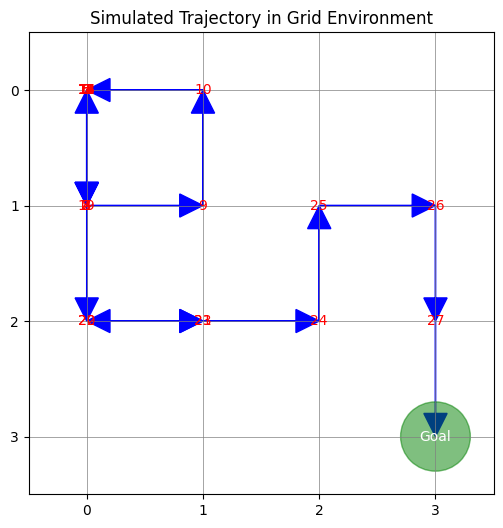

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Define the grid size and trajectory data
grid_size = 4
trajectory = [
    ((0, 0), 'down', -1, (1, 0)),
    ((1, 0), 'left', -1.5, (1, 0)),
    ((1, 0), 'left', -1.5, (1, 0)),
    ((1, 0), 'up', -1.5, (0, 0)),
    ((0, 0), 'left', -1.5, (0, 0)),
    ((0, 0), 'up', -1.5, (0, 0)),
    ((0, 0), 'down', -1.5, (1, 0)),
    ((1, 0), 'right', -1, (1, 1)),
    ((1, 1), 'up', -1, (0, 1)),
    ((0, 1), 'left', -1.5, (0, 0)),
    ((0, 0), 'left', -1.5, (0, 0)),
    ((0, 0), 'up', -1.5, (0, 0)),
    ((0, 0), 'left', -1.5, (0, 0)),
    ((0, 0), 'up', -1.5, (0, 0)),
    ((0, 0), 'up', -1.5, (0, 0)),
    ((0, 0), 'up', -1.5, (0, 0)),
    ((0, 0), 'left', -1.5, (0, 0)),
    ((0, 0), 'down', -1.5, (1, 0)),
    ((1, 0), 'down', -1, (2, 0)),
    ((2, 0), 'right', -1, (2, 1)),
    ((2, 1), 'left', -1.5, (2, 0)),
    ((2, 0), 'right', -1.5, (2, 1)),
    ((2, 1), 'right', -1, (2, 2)),
    ((2, 2), 'up', -1, (1, 2)),
    ((1, 2), 'right', -1, (1, 3)),
    ((1, 3), 'down', -1, (2, 3)),
    ((2, 3), 'down', 10, (3, 3))
]

# Create the grid
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-0.5, grid_size - 0.5)
ax.set_ylim(-0.5, grid_size - 0.5)
ax.set_xticks(range(grid_size))
ax.set_yticks(range(grid_size))
ax.grid(color='gray', linestyle='-', linewidth=0.5)
ax.set_title("Simulated Trajectory in Grid Environment")
ax.invert_yaxis()  # Invert y-axis to align with (0, 0) at the top-left

# Plot the trajectory
for i, step in enumerate(trajectory):
    state, action, reward, next_state = step
    x1, y1 = state
    x2, y2 = next_state

    # Draw the arrow for movement
    ax.arrow(
        y1, x1, y2 - y1, x2 - x1, head_width=0.2, head_length=0.2, fc='blue', ec='blue', length_includes_head=True
    )

    # Annotate the action and step number
    ax.text(y1, x1, str(i + 1), color="red", fontsize=10, ha="center", va="center")

# Mark terminal state
terminal_state = trajectory[-1][-1]  # (3, 3)
ax.add_patch(plt.Circle((terminal_state[1], terminal_state[0]), 0.3, color='green', alpha=0.5))
ax.text(terminal_state[1], terminal_state[0], "Goal", color="white", fontsize=10, ha="center", va="center")

# Display the grid
plt.show()


This plot illustrates a **simulated trajectory in a grid environment** where an agent moves through the grid and eventually reaches the goal state.

### Key Elements:
1. **Blue Arrows**:
   - Indicate the direction of movement between states (grid cells) along the agent's trajectory.

2. **Red Numbers**:
   - Represent the step index in the trajectory, showing the sequence in which the states were visited.

3. **Green Circle**:
   - Marks the **goal state** `(3,3)` where the agent's movement ends.

4. **Grid Layout**:
   - The grid represents the environment in which the agent navigates.
   - States are represented by the intersections of the grid lines.

### Observations:
1. **Trajectory Path**:
   - The agent starts at `(0,0)` and follows a non-linear path with several detours and loops before reaching the goal state `(3,3)`.
   - Repeated visits to earlier states indicate inefficiencies in the agent's policy or exploration strategy.

2. **Efficiency**:
   - The trajectory contains redundant steps, as the agent revisits states it has already traversed (e.g., `(0,0)` and `(1,0)` multiple times).

3. **Goal Reached**:
   - The agent successfully reaches the goal state, but it takes an indirect path, which could be improved.

4. **Potential Loops**:
   - From the numbering sequence, it appears the agent revisits certain cells. For example:
     - `(0,0)` is visited early and then revisited later, as evidenced by sequential jumps in the step numbers.

### Analysis:
- **Redundancy**: Revisits to previously explored states indicate that the policy or algorithm guiding the agent's movements is not fully optimized for shortest-path efficiency.
- **Exploration Strategy**: The agent may be using a strategy that encourages exploration (e.g., ε-greedy or random walks), leading to revisits of known states.
- **Goal-Oriented Behavior**: Despite the inefficiencies, the agent successfully completes its task of reaching the goal.

#2. Exploring State Visitation Patterns
The heatmap in the visualization highlights how frequently each state is visited:
States with higher visitation frequency (darker shades) indicate areas where the agent may get "stuck" or frequently loops.
By identifying these patterns, we can evaluate the agent's exploration versus exploitation behavior.


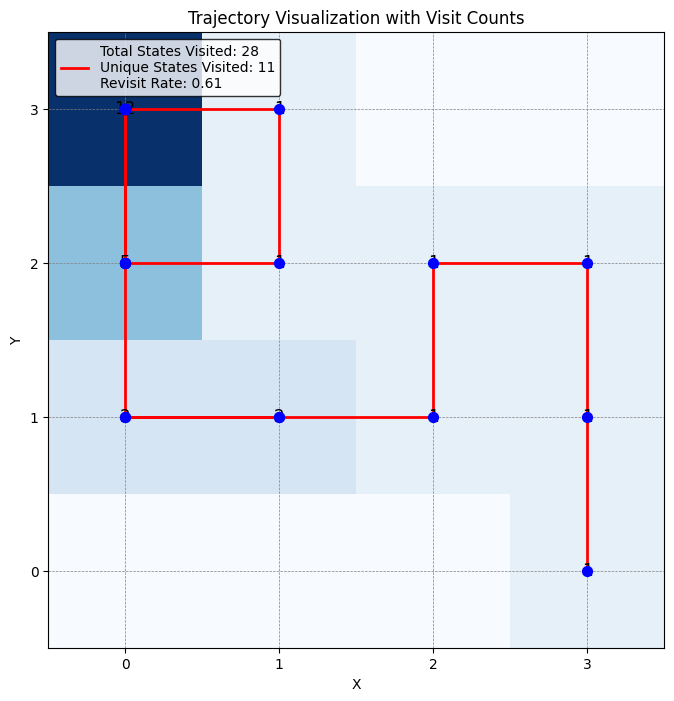

Trajectory Metrics:
Total States Visited: 28
Unique States Visited: 11
Revisit Rate: 0.61

Visit Counts:
State (0, 0): 12 visits
State (0, 1): 1 visits
State (1, 0): 5 visits
State (1, 1): 1 visits
State (1, 2): 1 visits
State (1, 3): 1 visits
State (2, 0): 2 visits
State (2, 1): 2 visits
State (2, 2): 1 visits
State (2, 3): 1 visits
State (3, 3): 1 visits


In [7]:
# Extract states and count visits
states = [step[0] for step in trajectory] + [trajectory[-1][-1]]
visit_counts = Counter(states)
unique_states = set(states)

# Calculate metrics
total_visits = len(states)
unique_visits = len(unique_states)
revisit_rate = (total_visits - unique_visits) / total_visits

# Create a grid visualization
grid_size = 4
grid = np.zeros((grid_size, grid_size))

# Mark visit counts on the grid
for (x, y), count in visit_counts.items():
    grid[x, y] = count

# Visualization
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(grid, cmap='Blues', origin='upper', extent=[-0.5, grid_size-0.5, -0.5, grid_size-0.5])

# Add annotations for visit counts
for i in range(grid_size):
    for j in range(grid_size):
        if grid[i, j] > 0:
            ax.text(j, grid_size-1-i, f"{int(grid[i, j])}", ha='center', va='center', fontsize=12, color='black')

# Draw trajectory
x_coords, y_coords = zip(*[(state[1], grid_size-1-state[0]) for state in states])
ax.plot(x_coords, y_coords, color='red', linewidth=2, label="Trajectory")
ax.scatter(x_coords, y_coords, color='blue', s=50, zorder=5)

# Add metrics to the legend
legend_text = f"Total States Visited: {total_visits}\nUnique States Visited: {unique_visits}\nRevisit Rate: {revisit_rate:.2f}"
ax.legend([legend_text], loc="upper left", fontsize=10, frameon=True, edgecolor='black')

# Finalize plot
ax.set_xticks(range(grid_size))
ax.set_yticks(range(grid_size))
ax.set_xticklabels(range(grid_size))
ax.set_yticklabels(range(grid_size))
ax.set_title("Trajectory Visualization with Visit Counts")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

# Print metrics
print(f"Trajectory Metrics:")
print(f"Total States Visited: {total_visits}")
print(f"Unique States Visited: {unique_visits}")
print(f"Revisit Rate: {revisit_rate:.2f}")
print("\nVisit Counts:")
for state, count in sorted(visit_counts.items()):
    print(f"State {state}: {count} visits")



### Output:

1. **Grid Visualization**:
   - A grid map showing visit counts at each cell.
   - The trajectory path is drawn in red, and visit counts are marked inside the cells.

2. **Legend**:
   - Total states visited.
   - Unique states visited.
   - Revisit rate.

3. **Console Output**:
   - **Metrics**: Total visits, unique visits, revisit rate.
   - **Visit counts**: Breakdown of visits for each state.

---

### How it helps:
1. Identifies which states are revisited often.
2. Displays metrics for trajectory evaluation.
3. Helps in optimizing trajectory planning to minimize revisits.

### Key Elements:
1. **Red Path**:
   - Represents the agent's movement trajectory across the grid.
   - The red lines connect the sequence of states visited by the agent.

2. **Blue Dots**:
   - Mark specific grid cells (states) visited by the agent.

3. **Cell Shading (Heatmap)**:
   - The intensity of the blue color in each cell represents the visit count:
     - Darker blue = Higher number of visits.
     - Lighter blue or no shading = Fewer or zero visits.

4. **Annotations Inside the Cells**:
   - Numbers inside each grid cell indicate the exact number of times the agent visited that cell.

5. **Legend**:
   - **Total States Visited**: Total number of steps the agent took (including revisits).
   - **Unique States Visited**: Number of unique cells visited.
   - **Revisit Rate**: Proportion of revisits relative to total visits. A higher revisit rate suggests inefficiency in the trajectory.

### What It Shows:
- **Frequent Revisits**: Cells at `(0,0)` and nearby states show darker shading and higher visit counts, indicating that the agent revisits those cells multiple times.
- **Exploration vs. Revisit**: Although 28 steps were taken in total, only 11 unique states were visited. This indicates significant redundancy in the agent's path.
- **Final State**: The trajectory ends at `(3,3)`, a lightly visited cell (possibly the target or goal state).

### Analysis:
- The agent's trajectory demonstrates **inefficient exploration**, as it revisits several states repeatedly, especially near the starting area (`(0,0)`) and along certain paths.
- Optimizing the path (e.g., using a better policy in reinforcement learning) could reduce the revisit rate, leading to more efficient navigation.
